# Import libraries

In [9]:
#from plot_prop import plot_direction, plot_pointcloud, plot_segments, plot_projection, plot_all_projections
from prop_info import extreme_points, vect_blade, d_blade
from get_segments import blade_alone, get_segments_points, get_planes
from major_axis import get_major_axis
from projections import projections_by_side, couple_all_planes, project_all_couples
from myMathFunction import distance_point_plane
import pandas as pd
import numpy as np

## Pre-processing

In [5]:
propeller_coords = pd.read_csv('aerostar_data.csv')

max_point, min_point, middle_point, highest_point, lowest_point = extreme_points(propeller_coords)

vect_length = vect_blade(max_point, min_point) 

dmiddle, dhighest, dlowest = d_blade(vect_length, middle_point, highest_point, lowest_point)

upper_blade, lower_blade = blade_alone(propeller_coords, vect_length, dmiddle)

vect_out, vect_side = get_major_axis(propeller_coords, middle_point, vect_length)

## Projections

In [6]:
nb_seg = 5
planes = get_planes(upper_blade, dmiddle, dhighest, vect_length, nb_seg)

segments = get_segments_points(upper_blade, planes, nb_seg)

nb_point = 1000
proj_up, proj_down, idx_down, idx_up = projections_by_side(nb_seg, planes, segments, nb_point)

couples = couple_all_planes(proj_down, proj_up, nb_seg)

In [173]:
proj_up, proj_down, idx_up, idx_down = projections_by_side(nb_seg, planes, segments, nb_point)

In [172]:
def projections_by_side(nb_seg, planes, segments, nb_point):
    proj_down = {}
    proj_up = {}
    
    idx_up = []
    idx_down = []

    for proj in range(1, nb_seg): #1,2,3,4
        df_d, df_u, idx_down_proj, idx_up_proj = project_on_plane(planes[proj], segments['points'][proj-1], segments['points'][proj], nb_point)
        proj_down[proj-1] = df_d
        proj_up[proj-1] = df_u
        
        idx_down.append(idx_down_proj) #0,1,2,3
        idx_up.append(idx_up_proj)
        
    return proj_up, proj_down, idx_up, idx_down

## Current work

In [234]:
def points_to_project(segments, idx_up, idx_down, couples, nb_seg):
    up_keep = []
    down_keep = []
    
    for i in range(nb_seg-1):
        up_keep.append( [segments['points'][i+1][j] for j in idx_up[i]] )
        down_keep.append( [segments['points'][i][j] for j in idx_down[i]] )
    
    up = []
    down = []
    
    for i, couple in enumerate(couples):
        up_points = [] 
        down_points = [] 
    
        for j, tup in enumerate(couple):  
            down_points.append(down_keep[i][tup[0]])        
            up_points.append(up_keep[i][tup[1]])
        
        up.append(up_points)
        down.append(down_points)
        
    return down, up

In [235]:
down, up = points_to_project(segments, idx_up, idx_down, couples, nb_seg)

In [245]:
from myMathFunction import point_on_plane
def project_couple(plane, proj_up, proj_down): 
    projection = []
    for i in range(len(proj_up)):
        projection.append( point_on_plane( proj_up[i], proj_down[i], plane ) )
        
    return projection

In [249]:
def project_all_couples(couples, planes, up, down):
    projections_df = {}
    projections_df['points'] = []
    
    projections = []
    labels = ['X', 'Y', 'Z']
    
    for i, couple in enumerate(couples):
        projections.append( project_couple(planes[i+1], up[i], down[i]) )
        
    for i, plan in enumerate(projections):
        projections_df['points'].append( pd.DataFrame(plan, columns = labels) )
        
    return projections_df

In [250]:
projections_df = project_all_couples(couples, planes, up, down)

In [251]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt

def plot_final_projections(projections_df):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for plan in projections_df["points"]:
        #print(plan)
        ax.plot(plan['X'], plan['Y'], plan['Z'], 'co', markersize=3, alpha=0.2)
        #for elem in plan.iterrows():
         #   ax.plot(elem[0], elem[1], elem[2], 'co', markersize=3, alpha=0.2)
    ax.set_xlabel('x_values', fontsize=15)
    ax.set_ylabel('y_values', fontsize=15)
    ax.set_zlabel('z_values', fontsize=15)
    plt.title('Projections on plane', fontsize=20)
    plt.show()
    fig.savefig('Projections_on_plane.png')

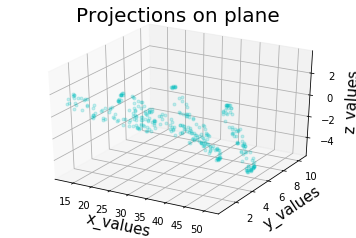

In [252]:
plot_final_projections(projections_df)

## Find parameters

To find:
    - Hub radius (Got the center. How to stop ?)
    - Tip radius (Projection dans le sens de la longueur et ...)
    - Blade twist (could project on plane as before from two point and see difference of angle between main directions)
    - Chord length (Max length - hus radius)